<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
%matplotlib inline

In [2]:
from scipy.stats import norm

In [3]:
# librerias

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [4]:
cats = pd.read_csv('data/cookie_cats.csv')
cats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
cats.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

# Ordenar los datos

In [6]:
g40 = cats[cats.version=='gate_40']
g30 = cats[cats.version=='gate_30']

In [7]:
g30

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False
...,...,...,...,...,...
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False


In [8]:
g40

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
7,1444,gate_40,2,False,False
...,...,...,...,...,...
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False


In [9]:
g30r1 =pd.crosstab(g30.version, g30.retention_1)
g30r7=pd.crosstab(g30.version, g30.retention_7)
g40r1 =pd.crosstab(g40.version, g40.retention_1)
g40r7 =pd.crosstab(g40.version, g40.retention_7)

In [10]:
g30r1 # aguantan al dia 1 en el grupo en control

retention_1,False,True
version,,
gate_30,24666,20034


In [11]:
g30r7 # aguantan al dia 1 en el grupo en tratamiento

retention_7,False,True
version,,
gate_30,36198,8502


In [12]:
g40r1 # aguantan al dia 7 en el grupo en control

retention_1,False,True
version,,
gate_40,25370,20119


In [13]:
g40r7 # Aguantan al dia 7 en el grupo en tratamiento

retention_7,False,True
version,,
gate_40,37210,8279


# Testeo

In [14]:
control = cats[cats.version=='gate_30'].sample(n=44700, random_state = 22)

tratamiento = cats[cats.version=='gate_40'].sample(n=44700, random_state=22)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test


,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True
...,...,...,...,...,...
89395,3795601,gate_40,35,True,False
89396,8984080,gate_40,136,True,False
89397,3853652,gate_40,66,False,True
89398,772383,gate_40,3,False,False


In [15]:
ab_test.retention_1.value_counts()



False    49607
True     39793
Name: retention_1, dtype: int64

# Retencion dia 1

In [16]:
control_res=ab_test[ab_test.version=='gate_40']['retention_1']

tratamiento_res=ab_test[ab_test.version=='gate_30']['retention_1']

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [18]:
tratamiento_res.sum()

20034

In [19]:
observaciones=[44700, 44700]  #control_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]   # conversiones por grupo


z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)  # diferencia significativa


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [20]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: -1.85
p-valor: 0.064
intervalo conf 95% para grupo control: [0.437, 0.447]
intervalo conf 95% para grupo tratamiento: [0.444, 0.453]


In [21]:
tasas_conversion=ab_test.groupby('version')['retention_1']
tasas_conversion.value_counts()

version  retention_1
gate_30  False          24666
         True           20034
gate_40  False          24941
         True           19759
Name: retention_1, dtype: int64

In [22]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo

std=lambda x: np.std(x, ddof=0)    # std

error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


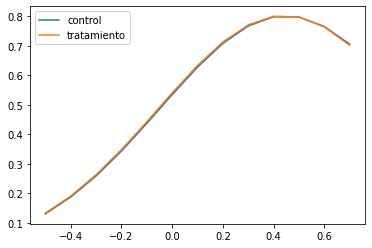

In [23]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

#  Retencion en el dia 7

In [26]:
control_res2=ab_test[ab_test.version=='gate_30']['retention_7']

tratamiento_res2=ab_test[ab_test.version=='gate_40']['retention_7']

In [27]:
observaciones=[44700, 44700]  #control_res.count()

conversiones2=[control_res2.sum(), tratamiento_res2.sum()]   # conversiones por grupo


z_score2, p_valor2 = proportions_ztest(conversiones2, nobs=observaciones)  # diferencia significativa


# intervalos de confianza

(control_c, tratamiento_c), (control_d, tratamiento_d) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [28]:
print(f'z-score: {z_score2:.2f}')
print(f'p-valor: {p_valor2:.5f}')
print(f'intervalo conf 95% para grupo control: [{control_c:.3f}, {control_d:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_c:.3f}, {tratamiento_d:.3f}]')

z-score: 3.19
p-valor: 0.00143
intervalo conf 95% para grupo control: [0.437, 0.447]
intervalo conf 95% para grupo tratamiento: [0.444, 0.453]


In [29]:
tasas_conversion2=ab_test.groupby('version')['retention_7']
tasas_conversion2.value_counts()

version  retention_7
gate_30  False          36198
         True            8502
gate_40  False          36569
         True            8131
Name: retention_7, dtype: int64

In [30]:
tasas_conversion2=ab_test.groupby('version')['retention_7']  # agrupo por grupo

std=lambda x: np.std(x, ddof=0)    # std

error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))

tasas_conversion2=tasas_conversion2.agg([np.mean, std, error_std])
tasas_conversion2.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion2.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


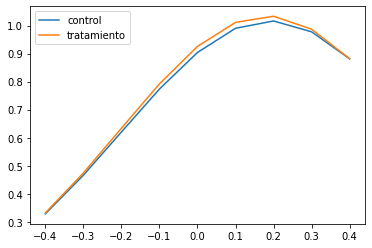

In [31]:
x=[i*.1 for i in range(-4, 5)]  

control2=[norm.pdf(x, tasas_conversion2.iloc[0][0], tasas_conversion2.iloc[0][1]) for x in x] 

tratamiento2=[norm.pdf(x, tasas_conversion2.iloc[1][0], tasas_conversion2.iloc[1][1]) for x in x] 

plt.plot(x, control2)
plt.plot(x, tratamiento2)
plt.legend(['control', 'tratamiento']);

En cuanto a la retencion del dia 1 vemos que no hay diferencia significativa entre el grupo de control y el grupo en tratamiento, por lo que podemos rechazar H0.

En cuanto a la retrencion del dia 7 vemos que si que hay algo de diferencia entre el grupo de control y el grupo en tratamiento pero no es una diferencia significativa, por lo tanto no creo que tenga relevancia el cambiar el punto de pagar o no en la puerta 40 en ninguno de ambos dias.